In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


## Import Section
### To accelerarate our computation, let's switch to GPU T4 x2.

In [2]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently operating on {device}')
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from random import shuffle, seed 
from glob import glob


Currently operating on cuda


### Install torchsummary library to visualize our model.


In [3]:
!pip install torchsummary
from torchsummary import summary

## Organize and prepare our data pipeline

### Let's create a dataframe for our csv file and make it more organized.

In [4]:
#Sort values in the csv values to concord with the file
path_csv = '*/metadata.csv'
df = pd.read_csv(path_csv)

df.head()

,filename,label
0,dirty_2.jpg,1
1,clean_36.jpg,0
2,clean_31.jpg,0
3,dirty_69.jpg,1
4,clean_113.jpg,0


### Since we only have one file with images, we will need to create train and test set:
1. Create two lists for clean and dirty roads images paths
2. Combine them both to have clean road images come first and dirty road images second.
<br /> This will also help us to create a test file where clean and dirty images will be equally distributed.

In [5]:
mypath = '*/Images'
#Organize clean and dirty images in two sections
clean = glob(mypath + '/clean*')
dirty = glob(mypath + '/dirty*')
fpaths = clean+dirty
# Check the len of our images file and len of our dataframe
print(f'CSV shape: {df.shape}, img_file shape: {len(fpaths)}')

CSV shape: (237, 2), img_file shape: 237


### Let's plot the distribution of our images

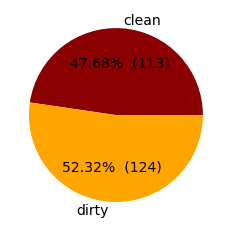

In [6]:
# Plot to see the distribution 
df_label = df['label'].value_counts()
plt.figure(figsize=plt.figaspect(1))
values = [df_label[0], df_label[1]]
labels = ['clean', 'dirty']
colors = ['darkred','orange']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, autopct=make_autopct(values), textprops={'fontsize': 14}, colors = colors)
plt.style.use('classic')
plt.show()

### From the plot above, we can see that images are quite equally distributed. 

# Data pipeline with PyTorch Dataset Class
### 1. First, we want to create train and test lists. 
<br /> We will be using 197 images for train and 40 images for test.
<br /> To assure an equal distribution for test images, we will grab 20 elements from the beginning and 20 elements from the end of our above created path list.

In [7]:
fpaths_train = fpaths[21:-19]
fpaths_test = fpaths[0:21]
fpaths_test.extend(fpaths[-19:])

#If you want to make sure that there is no same images in both files - run the following code:
check =  any(item in fpaths_test for item in fpaths_train)
 
if check is True:
    print("The test list  contains some elements of the train list ")    
else :
    print("No, test list doesn't have any elements of the train list.")

No, test list doesn't have any elements of the train list.


### 2. Let's create our Dataset class.
<br /> Our only argument for the class will be the training or testing folder. 
<br /> Inside the __init__() we will initialize our normalization function (this is necessary if we want to work with VGG16).
<br /> We also shuffle our data randomly, to avoid constant flow of clean or dirty road images.
<br /> Our targets will be assessed by a list comprehension where if the path has "dirty", it will be labeled as True (or 1) and "clean" will be labeled as False (0). 
<br /> The targets will match the labels of our csv file.
<br /> Then, we will transform our file into a cv2.image and then into a normalized Tensor.
<br /> Our targets will be transformed into a Tensor (True --> 1, False --> 0) 


In [8]:
class clean_dirty(Dataset):
    def __init__(self, folder):
        #clean = glob(folder + '/clean*')
        #dirty = glob(folder + '/dirty*')
        self.fpaths = folder
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std = [0.229, 0.224, 0.225])
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dirty') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__ (self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

### 3. Let's make sure that our class works. 
<br /> Create an instance of our above class.
<br /> Select a random sample, and plot it.

torch.Size([3, 224, 224])
/kaggle/input/cleandirty-road-classification/Images/Images/clean_21.jpg
tensor([0.], device='cuda:0')


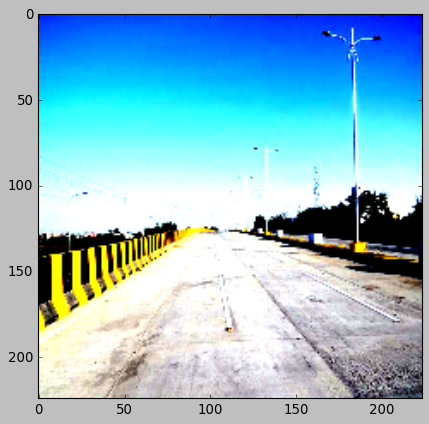

In [9]:
train = clean_dirty(fpaths_test)
import random

idx = random.randint(0, len(train)-1)

im, label = train[idx]
print(im.shape)
print(train.fpaths[idx])
plt.imshow(im.permute(1,2,0).to('cpu')) # Don't forget to load the image on cpu since Matplot does not operate with cuda 
print(label)

### Our class works perfectly, let's create our model and train it.

# VGG16
## This model has been trained on various tasks, such as autonomous driving. Thus, it will be able to discriminate our road images very well.
### Let's download our model and look at it summary.

In [10]:
model = models.vgg16(pretrained = True).to(device)
summary(model, input_size = (3,224,224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Since we are working with a binary classification, we need to modify our classification features of the VGG16. 
<br /> We will also change our AdaptiveAvgPool2d's output feature map size from (7,7) to (1,1) to fit with our classification layers.
<br /> Change the output layer to a sigmoid unit since it is a binary classification. 
<br /> We will use binary cross entropy loss function for this task.
<br /> We will select Adam as our optimizer with a learning rate of 1e-3.
<br /> Last, load the model on our device. 

In [11]:
def get_model():
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512,128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128,1),
                                     nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    return model.to(device), loss_fn, optimizer


### This is an optional code if you want to see the differences between VGG16 and our modifications via torch summary.

In [12]:
custom_model, criterion, optimizer = get_model()
summary(custom_model, input_size = (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Let's create our functions for training, accuracy and data extraction. 

In [13]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad() #This is a decorator that blocks and gradient computations for our accuracy function. 
def accuracy(x,y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    
    train_data = clean_dirty(fpaths_train) 
    test_data = clean_dirty(fpaths_test) 
    
    
    trn_dl = DataLoader(train_data, batch_size = 32, shuffle = True,
                        drop_last = True)
    val_dl = DataLoader(test_data, batch_size = 32, shuffle = True,
                          drop_last=True)
    

    return trn_dl, val_dl

### Obtain all your variables before starting the training and testing process.

In [14]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

### Let's create our training loop of 15 epochs.
1. Create the main for loop, specify the amount of epochs.
2. Create a for loop for training, where we will use our training dataset.
3. Create a for loop for accuracy calculations of our training set. 
4. Create a for loop for validation. 
5. Append all your outputs of for loops to their appropriate lists. 

In [15]:
train_losses, train_accuracies = [], []
val_accuracies = []

# xtr = torch.empty((32,3,224,224))

for epoch in range(15):#changed it for speed
    print(f'epoch {epoch+1}/15')
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        # print(x.shape)
        batch_loss = train_batch(x,y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f'Loss for current epoch of {epoch+1} is {train_epoch_loss}')

    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f'Accuracy the for current epoch of {epoch+1} is {train_epoch_accuracy}')
    
    for ix, batch in enumerate(iter(val_dl)):
        x,y = batch
        val_is_correct = accuracy(x,y,model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print(f'Val accuracy for current epoch of {epoch+1} is {val_epoch_accuracy}')
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1/15
Loss for current epoch of 1 is 0.606539323925972
Accuracy the for current epoch of 1 is 0.9479166666666666
Val accuracy for current epoch of 1 is 0.9375
epoch 2/15
Loss for current epoch of 2 is 0.3640034844477971
Accuracy the for current epoch of 2 is 0.96875
Val accuracy for current epoch of 2 is 0.9375
epoch 3/15
Loss for current epoch of 3 is 0.22026162346204123
Accuracy the for current epoch of 3 is 0.9635416666666666
Val accuracy for current epoch of 3 is 0.90625
epoch 4/15
Loss for current epoch of 4 is 0.1429507794479529
Accuracy the for current epoch of 4 is 0.9635416666666666
Val accuracy for current epoch of 4 is 0.90625
epoch 5/15
Loss for current epoch of 5 is 0.10908542076746623
Accuracy the for current epoch of 5 is 0.9635416666666666
Val accuracy for current epoch of 5 is 0.9375
epoch 6/15
Loss for current epoch of 6 is 0.09686818718910217
Accuracy the for current epoch of 6 is 0.9791666666666666
Val accuracy for current epoch of 6 is 0.9375
epoch 7/15
Loss f

### Let's plot our validation and training accuracy to assess our model's performance.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


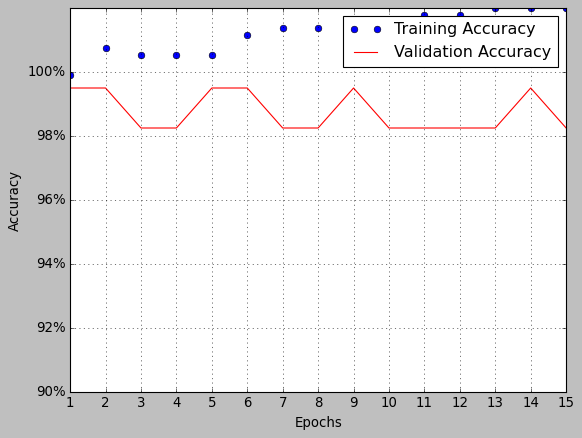

In [16]:
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure

epochs = np.arange(15) + 1
figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, train_accuracies, 'bo',
         label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r',
         label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.ylim(0.70,1)
plt.legend()
plt.grid('off')
plt.show()
    

## Conclusions about our model's performance: 
### 1. From the discrepancy of the training and validation accuracy, we can state that our model overfits the data.
### 2. This is not very surprising, we have a limited amount of data which can casuse this problem.
### 3. We can try to perform some data augmentation techniques, or scrape the internet for more examples. 

# Custom images test section.
### This section allows you to import images from online and test them on our above trained model. 

In [17]:
import urllib
import cv2


def predict_custom_img(url):
    
    resp = urllib.request.urlopen(url)
    img = np.asarray(bytearray(resp.read()), dtype = 'uint8')
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224))
    img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.permute(0,1,2,3)
    print(img1.shape)
    prediction = model(img1)
    if prediction < 0.5:
        a = str(f'This is a clean street with a score: {prediction}')
    else:
        a = str(f'This is a dirty street with a score: {prediction}')
    plt.style.use('dark_background')
    plt.imshow(img)
    plt.title(a)
    return img1

torch.Size([1, 3, 224, 224])


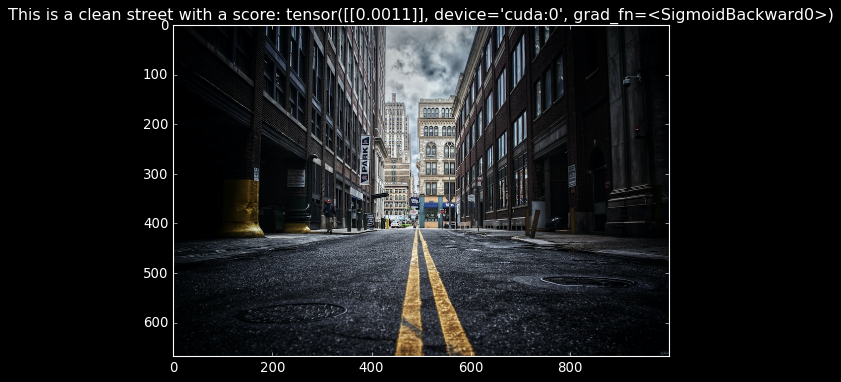

In [18]:
img = predict_custom_img('https://images.unsplash.com/photo-1539651044670-315229da9d2f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTF8fHN0cmVldHxlbnwwfHwwfHw%3D&w=1000&q=80')

torch.Size([1, 3, 224, 224])


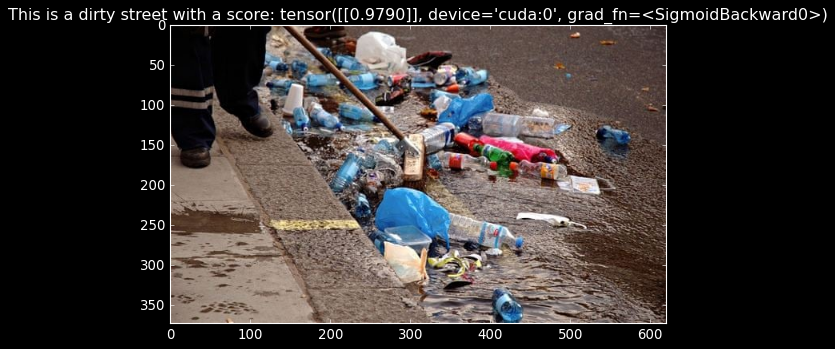

In [19]:
img1 = predict_custom_img('https://i.guim.co.uk/img/static/sys-images/Guardian/Pix/pictures/2014/11/12/1415823114184/dirty-street-012.jpg?width=620&quality=85&auto=format&fit=max&s=36cbed88f668c3f0cf640e4712ce62f4')